# Time Series Analysis Using Regression

In this notebook I am going to look through a single example on predicting a time series forecast using regression methods. These methods are the same to the regression methods that we saw earlier in the course when looking at predicing a dependant variable such as house price from independant variables such as number of bedrooms and area of the city. However in the case of time series data we are going to look at how other variables can be used to help predict a forecast. 

## <a id='1'> **Stage 1. Package and Data Import** </a>

### Import Packages

As usual, one of the first steps is to import the libraries we'll need throughout the analysis.

In [1]:
## Import packages
import pandas as pd               # Used to work with tables in Python
import numpy as np                # Used to work with arrays and Pandas Series (columns)
import matplotlib.pyplot as plt   # A useful visualisation package
import seaborn as sns             # Another useful visualisation package
import statsmodels.api as sm

### Get the Data

We are going to work with some data that has already been cleaned for us to make this notebook nice and short and to the point. The data is looking at energy demand for a city in spain over time. We have infomation on the data/ time and the energy demand on the city as well as the temperature

In [2]:
df = pd.read_csv('https://github.com/DrPBaksh/workshop-data/blob/main/temperature_load.csv?raw=true')
df.head()

,date_time,total load actual,temp_mean,date,time
0,2015-01-01 00:00:00,25385.0,270.475,2015-01-01,00:00:00
1,2015-01-01 01:00:00,24382.0,270.475,2015-01-01,01:00:00
2,2015-01-01 02:00:00,22734.0,269.686,2015-01-01,02:00:00
3,2015-01-01 03:00:00,21286.0,269.686,2015-01-01,03:00:00
4,2015-01-01 04:00:00,20264.0,269.686,2015-01-01,04:00:00


## <a id='1'> **Stage 2. Clean Data and any EDA** </a>

THis data is mostly clean so this wont be comprehensive here

This is a personal preference. I am going to rename the total load actual to a single word so it is easier to call in the rest of this analysis

In [3]:
df.rename(columns = {'total load actual' : 'load'}, inplace =  True)

It is always a good idea to plot your data in order to see what the time series looks like. In a more comprehensive notebook you should check the statisitics of your data / missing values in the **EDA** phase however to keep this notebook focused on using *regression* for time series forecasting we shall keep this light touch. 

When I first went to plot this it gave a horrible line graph that made no sense. This was because python had not recognised the date_time column as a date. We are going to set that column as a date and also look to make it an index for now

In [4]:
df['date_time'] = pd.to_datetime(df.date_time)
df.set_index('date_time', inplace = True)

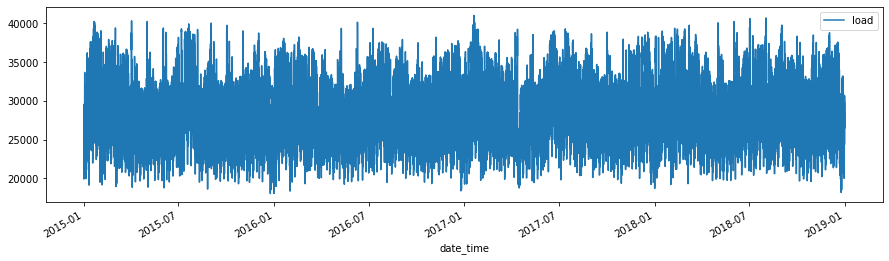

In [5]:
df.plot(y = 'load')
fig = plt.gcf()

fig.set_size_inches(15, 4)

This is showing all the data lets have a look at just the last year

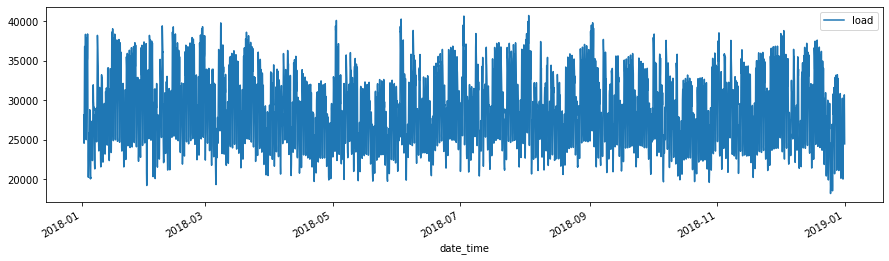

In [6]:
df.query('date > "2018-01-01"').plot( y = 'load')
fig = plt.gcf()
fig.set_size_inches(15, 4)


We can see some more detail but still not enough . Lets go to just one month

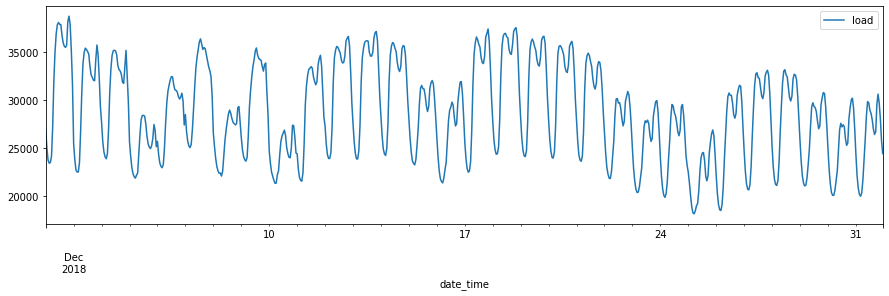

In [7]:
df.iloc[int(24*30)*-1 :].plot( y = 'load')
fig = plt.gcf()
fig.set_size_inches(15, 4)


Now we can see the repeating pattern in energy demand that looks to fluctaute every day and then every week there is a pattern and in the longer term period there looks to be fluctuation throughout the year. 



### What could be influencing our actual load

- In our dataset we have the temperature. This could be. When considering your problem features external to the time series could definitly be used as a factor to help predict your time series
- Time of day : We are seeing fluctuations within a 24 hour period. This is telling us we need to include time of day in a regression forecast
- Day of the week: There looks to be fluctuations in demand depending on the day of the week. If this is the case we need to include this as a feature in our predictin
- Month of the year : Does the data look to be changing depending on Month? It looks like it is. If we are unsure we can group the data by month and have a look at this?
- Year : Is the data changing year by year. If it is this needs to be a feature that we can include in our regression analysis. 

##### Other variables to consider
- lag variables : These are variables that we can create based on, in this case, averages of the load over a period prior to the forecast. These can sometimes be influencial in forecasting
- Holiday specific dates : National holidays  are good candidates for these. Depending on the problem there could be other dates around the year that could be included in a regression analysis. For example prediciting holiday bookings will not just be dependant on the seasonal date however there will be a large influence on the school holidays. Having a column that lets the algorithm know if this date is a school holiday or not is likely to improve your forecast signficantly. 

### Basic model - Single variable 
- The first model we shall create is a linear regression model based on predicting the load given the temperature. 

## <a id='1'> **Stage 3. Prepare data for ML** </a>

#### Train test split

- As with all machine learning problems we need to generate our training and our testing data
- We are just going to use one testing split. 
- Note sklearn does provide a more robust method for train test split on time series data that takes multiple folds in time . Infomation on this can be found in the following links. https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e . https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html



In [8]:
thresh = 0.95 #  95 % of the data used for training
y = df['load']
X = df.iloc[:, [1]]
X_train = X.iloc[:int(len(X) * thresh), :]
X_test = X.iloc[int(len(X) * thresh):, :]
y_train = y[:int(len(X) * thresh)]
y_test = y[int(len(X) * thresh):]

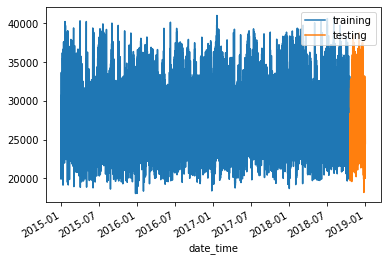

In [9]:
y_train.plot(y = 'load')
y_test.plot(y = 'load')
plt.legend(['training', 'testing'])

## <a id='1'> **Stage 4.Model Building** </a>

In [10]:
model = sm.OLS(y_train, X_train,missing='raise').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   load   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                          1.378e+06
Date:                Fri, 27 Jan 2023   Prob (F-statistic):                        0.00
Time:                        15:26:40   Log-Likelihood:                     -3.2719e+05
No. Observations:               33310   AIC:                                  6.544e+05
Df Residuals:                   33309   BIC:                                  6.544e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp_mean     98.5967      0.084   1173.770      0.000      98.432      98.761
==============================================================================
Omnibus:                     3215.504   Durbin-Watson:                   0.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1041.152
Skew:                           0.140   Prob(JB):                    8.26e-227
Kurtosis:                       2.180   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## <a id='1'> **Stage 5. Model Evaluation** </a>

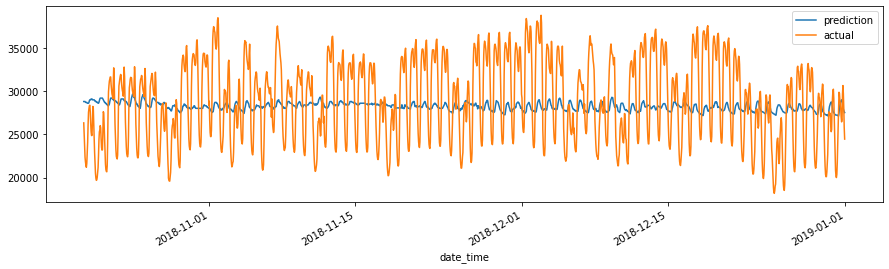

In [11]:
predictions= model.predict(X_test)
predictions.plot()
y_test.plot()
plt.legend(['prediction', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

### Evaluation Metrics

Lets make some basic evaluation metrics for these forecasts. For today lets use the Mean Average Percentage Error, residuals and the standard error



In [12]:
import numpy as np
def MAPE (x, y):
    pe_store = []
    for x , y in zip(x, y):
        pe = 100 * np.abs((x- y) / y)
        
        pe_store.append(pe)
    return np.mean(pe_store), pe_store

def standard_error(x, y):
    error = []
    for x , y in zip(x, y):
        error.append(np.abs((x- y)))
    return np.mean(error), error    

def resid(x, y):
    error = []
    for x , y in zip(x, y):
        error.append(((x- y)))
    return  error   

Checking the residuals are normally centred. 

<AxesSubplot:ylabel='Count'>

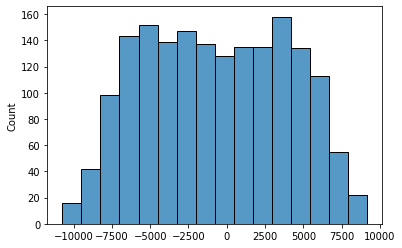

In [13]:
residuals = resid(predictions, y_test)
sns.histplot(residuals, kde=False)

In [14]:
se ,a  = standard_error(predictions, y_test)
print('standard error = ', se)

standard error =  4012.851025146794


Text(0.5, 1.0, 'MAPE = 14.18611619176432')

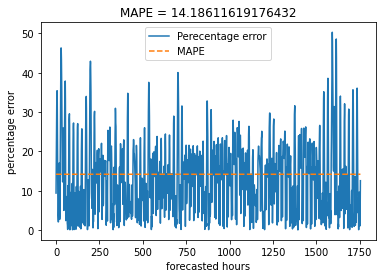

In [15]:
mape, pe= MAPE(predictions, y_test)

plt.plot(range(len(pe)), pe)
plt.plot(range(len(pe)), [mape] * len(pe), '--')
plt.legend(['Perecentage error', 'MAPE'])
plt.xlabel('forecasted hours')
plt.ylabel('percentage error')
plt.title ('MAPE = ' + str(mape)) 

**Now we have a baseline model we can begin to improve this model by creating more datetime features**

Lets break our date time out into time, day of week, month and year

In [16]:
df['year'] = [df.index[i].year for i in range(len(df))]
df['month'] = [df.index[i].month for i in range(len(df))]
df['time'] = [int(str(df.index[i].time())[0:2]) for i in range(len(df))]
df['dayofweek'] = [df.index[i].weekday() for i in range(len(df))]

In [17]:
df.head()

,load,temp_mean,date,time,year,month,dayofweek
date_time,,,,,,,
2015-01-01 00:00:00,25385.0,270.475,2015-01-01,0,2015,1,3
2015-01-01 01:00:00,24382.0,270.475,2015-01-01,1,2015,1,3
2015-01-01 02:00:00,22734.0,269.686,2015-01-01,2,2015,1,3
2015-01-01 03:00:00,21286.0,269.686,2015-01-01,3,2015,1,3
2015-01-01 04:00:00,20264.0,269.686,2015-01-01,4,2015,1,3


Now we have generated some time features lets fit a a lnear regression using the OLS algorithm. However first we need to redo X_train and y_train

In [18]:
thresh = 0.95 #  95 % of the data used for training
y = df['load']
X = df.iloc[:, [1, 3, 4, 5, 6]]
X_train = X.iloc[:int(len(X) * thresh), :]
X_test = X.iloc[int(len(X) * thresh):, :]
y_train = y[:int(len(X) * thresh)]
y_test = y[int(len(X) * thresh):]

In [19]:
X_train.head()

,temp_mean,time,year,month,dayofweek
date_time,,,,,
2015-01-01 00:00:00,270.475,0,2015,1,3
2015-01-01 01:00:00,270.475,1,2015,1,3
2015-01-01 02:00:00,269.686,2,2015,1,3
2015-01-01 03:00:00,269.686,3,2015,1,3
2015-01-01 04:00:00,269.686,4,2015,1,3


In [20]:
model_lr =  sm.OLS(y_train, X_train,missing='raise').fit()
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   load   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          4.040e+05
Date:                Fri, 27 Jan 2023   Prob (F-statistic):                        0.00
Time:                        15:26:42   Log-Likelihood:                     -3.2094e+05
No. Observations:               33310   AIC:                                  6.419e+05
Df Residuals:                   33305   BIC:                                  6.419e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp_mean     67.9551      3.041     22.345      0.000      61.994      73.916
time         338.2856      3.051    110.868      0.000     332.305     344.266
year           3.4883      0.429      8.126      0.000       2.647       4.330
month       -106.6336      6.324    -16.861      0.000    -119.029     -94.238
dayofweek   -448.2917     10.142    -44.201      0.000    -468.171    -428.413
==============================================================================
Omnibus:                      566.746   Durbin-Watson:                   0.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              500.267
Skew:                           0.247   Prob(JB):                    2.34e-109
Kurtosis:                       2.659   Cond. No.                     1.02e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see we get a really impressive R squared. Lets visualise the forecast on the X_test data and get some metrics

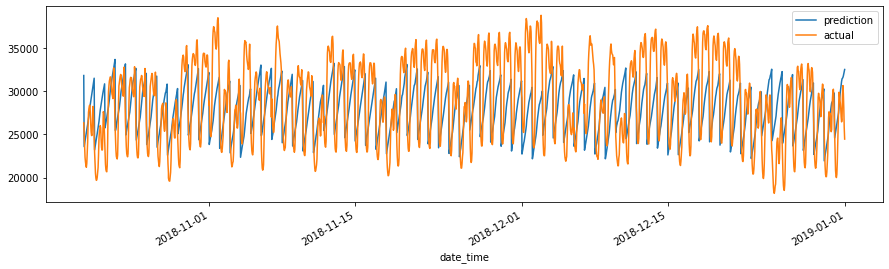

In [21]:
predictions= model_lr.predict(X_test)
predictions.plot()
y_test.plot()
plt.legend(['prediction', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

Lets make some basic evaluation metrics for these forecasts. For today lets use the Mean Average Percentage Error, residuals and the standard error



Checking the residuals are normally centred. 

<AxesSubplot:ylabel='Count'>

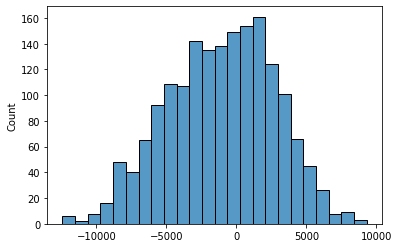

In [22]:
residuals = resid(predictions, y_test)
sns.histplot(residuals, kde=False)

In [23]:
se ,a  = standard_error(predictions, y_test)
print('standard error = ', se)

standard error =  3200.112270660058


Text(0.5, 1.0, 'MAPE = 10.905513832862667')

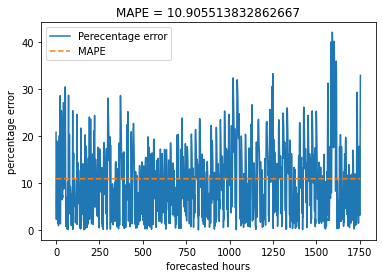

In [24]:
mape, pe= MAPE(predictions, y_test)

plt.plot(range(len(pe)), pe)
plt.plot(range(len(pe)), [mape] * len(pe), '--')
plt.legend(['Perecentage error', 'MAPE'])
plt.xlabel('forecasted hours')
plt.ylabel('percentage error')
plt.title ('MAPE = ' + str(mape)) 

Across the metrics we can see imporvements. Lets look in more detail in how the forecast is behaving over a shorter time period


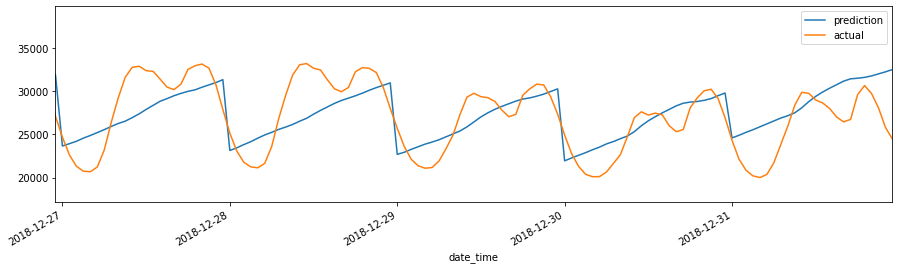

In [25]:
import datetime
predictions= model_lr.predict(X_test)
predictions.plot()
y_test.plot()
plt.legend(['prediction', 'actual'])
plt.xlim([y_test.index.max() - datetime.timedelta(days = 5), y_test.index.max()])
fig = plt.gcf()
fig.set_size_inches(15,4)

We can see the model does not have the flexibility to seem to fit to the rediction in load that we get at the peak of the day. This could be a limitation of using linear regression for our forecast. However we have other regression methods that have more flexibility to make an imporved prediction

##  <a id='1'> **Stage 6. Imporvement using XGBoost** </a>

*XGBoost (eXtreme Gradient Boosting) is a powerful and popular machine learning algorithm used for regression and classification problems. It is an implementation of gradient boosting framework. Gradient boosting is an ensemble method that combines multiple weak models, typically decision trees, to create a stronger model. XGBoost improves upon the traditional gradient boosting algorithm by using a more regularized model formalization to control over-fitting, which gives it better performance.The algorithm works by iteratively training decision tree models on the negative gradient of the loss function of the previous iteration. The decision tree models are trained using the gradient descent algorithm. The final model is a weighted sum of all the decision tree models.The algorithm also includes a built-in regularization term, which helps to reduce overfitting and improve generalization. This is done by introducing a penalty term for the number of terminal nodes in the trees, which is controlled by a parameter called "gamma".Additionally, XGBoost includes several other features such as parallel processing, handling missing values, built-in cross-validation, and handling categorical variables. It is widely used in many Kaggle competitions and industry applications because of its high performance, speed and scalability.*

Resources about XGBoost regressor
- https://xgboost.readthedocs.io/en/stable/python/python_intro.html
- https://www.youtube.com/watch?v=OtD8wVaFm6E

XGBoost is a very simple algorithm to train and uses the same class structure as scikit learn algroithms


In [26]:
# !pip install xgboost

In [27]:
from xgboost import XGBRegressor
model_xg = XGBRegressor()
model_xg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Just like that the regressor is trained with the default params. As we did with linear regression lets explore the results on the test data

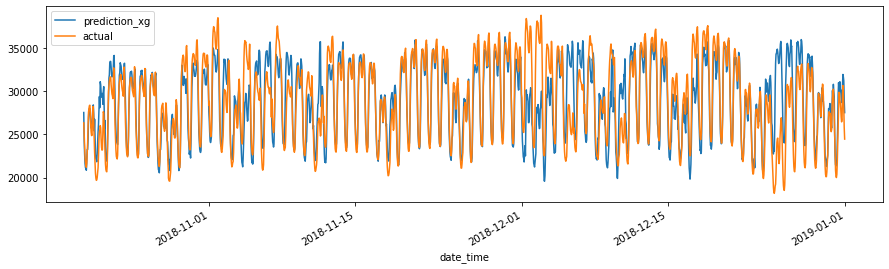

In [28]:
predictions_xg= pd.DataFrame({'xgb' :model_xg.predict(X_test), 'date': y_test.index})
predictions_xg.set_index('date', inplace = True)
predictions_xg.plot()
y_test.plot()
plt.legend(['prediction_xg', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

<AxesSubplot:ylabel='Count'>

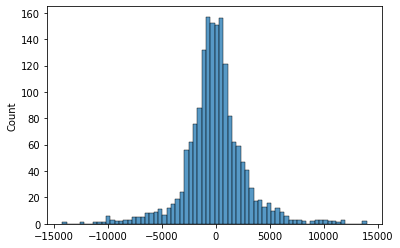

In [29]:
residuals_xg = resid(predictions_xg['xgb'], y_test)
sns.histplot(residuals_xg, kde=False)

In [30]:
se ,a  = standard_error(predictions_xg['xgb'], y_test)
print('standard error = ', se)

standard error =  1920.573256663341


Text(0.5, 1.0, 'MAPE = 6.751450865077799')

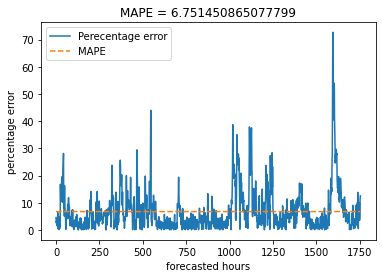

In [31]:
mape, pe= MAPE(predictions_xg['xgb'], y_test)

plt.plot(range(len(pe)), pe)
plt.plot(range(len(pe)), [mape] * len(pe), '--')
plt.legend(['Perecentage error', 'MAPE'])
plt.xlabel('forecasted hours')
plt.ylabel('percentage error')
plt.title ('MAPE = ' + str(mape)) 

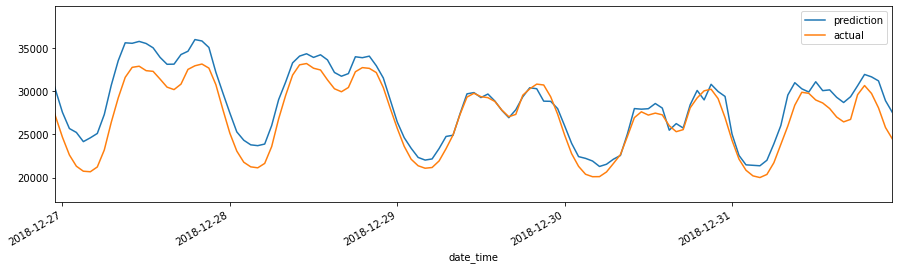

In [32]:
predictions_xg.plot()
y_test.plot()
plt.legend(['prediction', 'actual'])
plt.xlim([y_test.index.max() - datetime.timedelta(days = 5), y_test.index.max()])
fig = plt.gcf()
fig.set_size_inches(15,4)

The XGBoost regressor has showed it has the flexibility to fit the reduction in load that we see during the dat time that linear regression could not do.We can also have a look at the feature importance of the variables used to understand what was most influencial to the forecast 

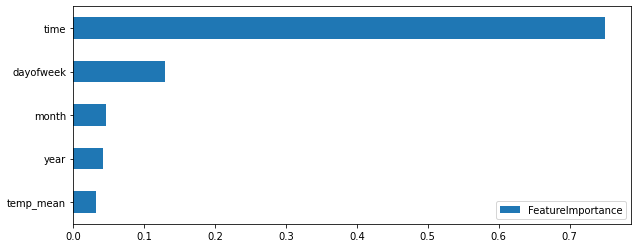

In [33]:
feat_imp_dict = dict(zip(X_train.columns, model_xg.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.query('FeatureImportance>0').sort_values(by=['FeatureImportance']).plot.barh();
fig = plt.gcf()
fig.set_size_inches(10, 4)

We can see from this that the time componenet is the most important feature in this forecast.

This notebook has gone through an example of how you could apply a regression in order to make a time series forecast



### Finish

### Bonus : lets explore how well our forecast can do with just time features and no temperature features

In [34]:
X_train.drop(columns = ['temp_mean'], inplace = True)
X_test.drop(columns = ['temp_mean'], inplace = True)

C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_26712\1845816722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns = ['temp_mean'], inplace = True)
C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_26712\1845816722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns = ['temp_mean'], inplace = True)


In [35]:
X_train.head()

,time,year,month,dayofweek
date_time,,,,
2015-01-01 00:00:00,0,2015,1,3
2015-01-01 01:00:00,1,2015,1,3
2015-01-01 02:00:00,2,2015,1,3
2015-01-01 03:00:00,3,2015,1,3
2015-01-01 04:00:00,4,2015,1,3


In [36]:
from xgboost import XGBRegressor
model_xg = XGBRegressor()
model_xg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

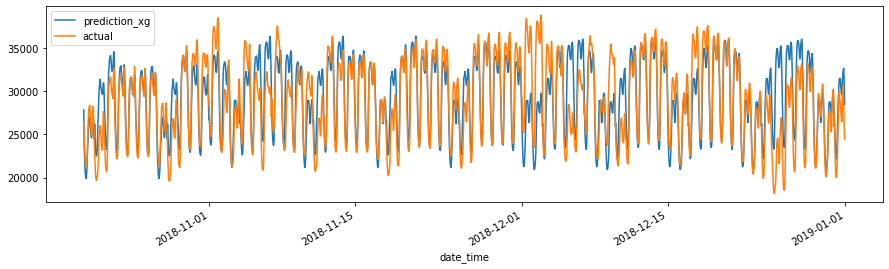

In [37]:
predictions_xg= pd.DataFrame({'xgb' :model_xg.predict(X_test), 'date': y_test.index})
predictions_xg.set_index('date', inplace = True)
predictions_xg.plot()
y_test.plot()
plt.legend(['prediction_xg', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

Text(0.5, 1.0, 'MAPE = 7.332212678201661')

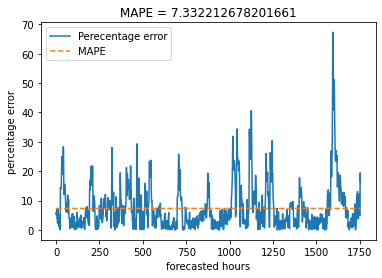

In [38]:
mape, pe= MAPE(predictions_xg['xgb'], y_test)

plt.plot(range(len(pe)), pe)
plt.plot(range(len(pe)), [mape] * len(pe), '--')
plt.legend(['Perecentage error', 'MAPE'])
plt.xlabel('forecasted hours')
plt.ylabel('percentage error')
plt.title ('MAPE = ' + str(mape)) 

Not bad, given we have based this forecast only on time features